In [1]:
import numpy as np
from sklearn import base, metrics
from sklearn.model_selection import KFold
import pandas as pd
from classifiers import *
from data_generation import *

## Data Viz

In [2]:
## Number of dimensions and classes
k = 3

## Number of data points
n = 1000

In [3]:
X,y = generate_simplex_data(k,n)

In [4]:
## Visualize Data Set
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(6,6))
plt.scatter([X[:, 0]], [X[:, 1]], c=y.T)

## Metrics and Code Needed to Perform Tests

In [5]:
def weighted_absolute_loss(u, y, alpha):
    y = np.array(y.T[0]) ## y is given as a column matrix, but predictions are not
    zs = np.zeros_like(y)
    return np.mean((1 - alpha) * np.maximum((u - y), zs) + alpha * np.maximum((y - u), zs))

In [6]:
def compute_alpha_quantile(X, alpha):
    n = X.shape[0]
    y = np.zeros((n, 1))
    w_alpha = alpha * 10 ## Simplex weighted to be 10 x 10
    for i in range(0, n):
        curr_vec = X[i,:]
        
        if(w_alpha < curr_vec[0]):
            y[i, 0] = 0
        elif(w_alpha  > curr_vec[-1]):
            y[i,0] = k - 1
        else:
            y[i,0] = np.argmax(curr_vec > w_alpha)
    return y

## Tests

In [11]:
k = 3
n = 1000
a1, a2, a3 = 0.3, 0.5, 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)

In [12]:
def train_classifiers(X_train, y_train, X_test, y_test, a, 
                      kernel='linear', kernel_param=1, loss_function='logistic'):
    results = {}
    y_quantiles = compute_alpha_quantile(X_test, a).astype(int)
    clf5 = LogisticQuantileIT(gamma=a, alpha=0.01, kernel_type=kernel, 
                              kernel_param=kernel_param, loss_function=loss_function)
    clf5.fit(X_train, y_train)
    preds_5 = clf5.predict(X_test)
    abs_loss = weighted_absolute_loss(preds_5, y_test, a)
    zo_loss = metrics.zero_one_loss(preds_5, y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'Preds': preds_5}

    clf6 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type=kernel, 
                              kernel_param=kernel_param, loss_function=loss_function)
    clf6.fit(X_train, y_train)
    preds_6 = clf6.predict(X_test)
    zo_loss = metrics.zero_one_loss(preds_6, y_quantiles)
    abs_loss = weighted_absolute_loss(preds_6, y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'Preds': preds_6}
    return results

In [13]:
results = train_classifiers(X_train, y_train, X_test, y_test, 0.3, 
                            kernel='poly', kernel_param=3, loss_function='hinge')

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.30360000000000004
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.521
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.3 0.30360000000000004
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.521


### Plot Decision Boundaries

LogisticQuantileIT(alpha=0.01, gamma=0.3, kernel_param=3, kernel_type='poly',
          loss_function='hinge', max_iter=1000, verbose=0)
[-8.60233117e-14  1.00000000e+00]


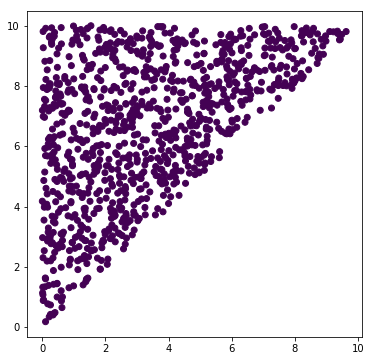

LogisticQuantileAT(alpha=1.0, gamma=0.3, kernel_param=3, kernel_type='poly',
          loss_function='hinge', max_iter=1000, verbose=0)
[-1.0583449e-13  1.0000000e+00]


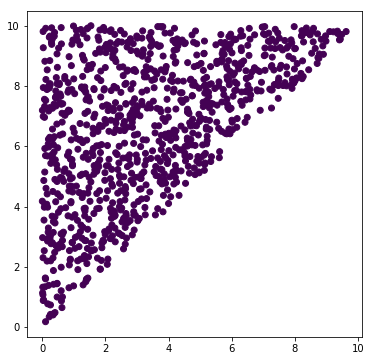

In [14]:
curr = results
for clf in curr.keys():
    print(clf)   
    print(clf.theta_)
    fig=plt.figure(figsize=(6,6))
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[curr[clf]['Preds'].T])
    plt.show()

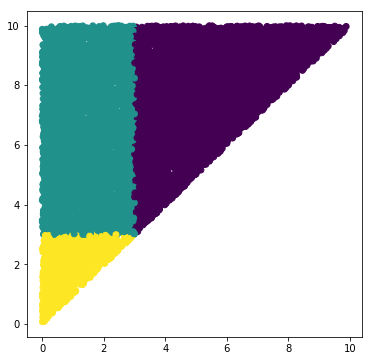

In [11]:
y_quantiles = compute_alpha_quantile(X_test, a1).astype(int)
fig=plt.figure(figsize=(6,6))
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)

## Cross-Validation (Small Scale)

In [7]:
k = 3
n = 1000
a1, a2, a3 = 0.3, 0.5, 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)

In [ ]:
## Cross Validation for rbf and polynomial kernel
quantiles = [a1, a2, a3]

reg_vals = [10**(-2), 10**(-1)]
q_vals = [2, 3]
gamma_vals = [10**(-1), 10**0]

cv_results_file = open('cv_results.csv', "w")
cv_results_file.write('Fold,Quantile,Surrogate,Kernel_Type,Kernel_Parameter,Regularization,01_Loss\n')
kf = KFold(n_splits=2)
kf.get_n_splits(X_train)
fold = 0
for train_index, test_index in kf.split(X_train):
    fold += 1
    curr_X_train, curr_X_test = X_train[train_index], X_train[test_index]
    curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]
    for a in quantiles:
        print('Fold ' + str(fold) + ' Quantile ' + str(a))
        a_test_quantiles = compute_alpha_quantile(curr_X_test, a)
        for reg in reg_vals:
            for q in q_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'IT' + ',' + 'poly' + ',' + str(q) + ',' + str(reg) + ',' + str(lossIT)
                cv_results_file.write(result_string + '\n')

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'AT' + ',' + 'poly' + ','+ str(q) + ',' + str(reg) + ',' + str(lossAT)
                cv_results_file.write(result_string + '\n')
                
            for g in gamma_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'IT' + ',' + 'rbf' + ',' + str(g) + ',' + str(reg) + ',' + str(lossIT)
                cv_results_file.write(result_string + '\n')

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result_string = str(fold) + ',' + str(a) + ',' + 'AT' + ',' + 'rbf' + ',' + str(g) + ',' + str(reg) + ',' + str(lossAT)
                cv_results_file.write(result_string + '\n')
    
cv_results_file.close()

In [ ]:
cv_results_from = pd.read_csv('cv_results.csv')
cv_results_from